### Score Based DiffM (Discrete-time) denoising

Consider a 1D noisy signal  
$$
y \in \mathbb{R}^n,\quad \mu = 0,\quad \mathrm{Cov}(y)=\Sigma.
$$  
We infer noise parameters  
$$
\mu = 0,\quad \Sigma
$$  
using Gibbs Sampling (+ HMC).

**Natural Images**  
$$
\Sigma_\sigma = \Sigma(\sigma,\psi)
$$  
where, sigma^2 = noise amplitude and psi = spectral indeex

**CMB**  
Model temperature fluctuations as  
$$
\mu = 0,\quad \mathrm{Cov}(y) = \Sigma_\phi,
$$  

where  
$$
\Sigma_\phi = \Sigma(H_0,\;\Omega_b,\;\sigma).
$$  

In both cases, we consider a covariance matrix that is diagonal in Fourier space. We write  
$$
\Sigma_\phi = \sigma^2 \cdot \mathbf{F}^\top \mathbf{D}_\psi \mathbf{F},
$$  
where F is the orthonormal discrete DFT matrix, sigma > 0 controls the noise amplitude, and D_psi is a diagonal matrix parameterized by the power spectrum function S_psi(k):  
$$
\mathbf{D}_\psi = \mathrm{diag}(S_\psi(k)).
$$  
$$
\text{Let } \varepsilon \text{ denote the predicted noise and } \hat{\varepsilon}_k = (\mathbf{F} \varepsilon)_k \text{ be its Fourier coefficients.}
$$
The log-posterior  (for HMC sampling) is given by
$$
\log p(\phi \mid \varepsilon = y - x) = \log p(\varepsilon \mid \phi) + \log p(\phi) + C
$$
Then the analytically tractable negative log-likelihood is given by:  
$$
- \log p(\varepsilon \mid \phi) = \frac{1}{2} \sum_k \left[ \log\left(\sigma^2 S_\psi(k)\right) + \frac{|\hat{\varepsilon}_k|^2}{\sigma^2 S_\psi(k)} \right] + C,
$$  
where \( C \) is an arbitrary constant.


#### The WorkFlow

1D execution -> 1D Gibbs-Sampling -> 2D Execution (alter 1D acc.) -> 2D Gibbs Sampling (alter 1D acc.) -> CMB inferencing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
import importlib
warnings.filterwarnings('ignore')

In [3]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [4]:
batch_size = 32
num_epochs = 20
train_split = 0.8

#### Data-Creation 1D (Synthetic)

In [45]:
import modules.utils.noise_create
importlib.reload(modules.utils.noise_create)
from modules.utils.noise_create import *

import modules.utils.metrics
importlib.reload(modules.utils.metrics)
from modules.utils.metrics import *

In [8]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

1D Flat PSD (white Noise) - Sine Signal

(10000, 100) (10000, 100) (10000, 100)


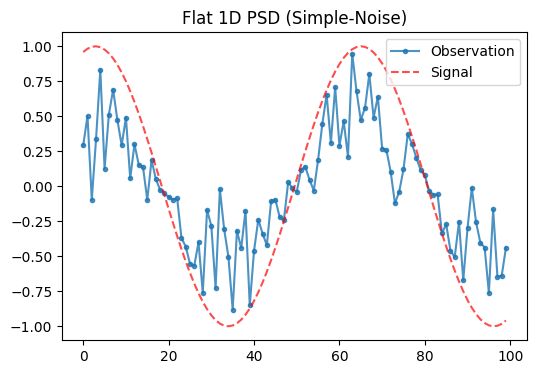

In [9]:
n_samples = 10000 ## num of samples
n_depth = 100 ## sequence-length
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples, n_depth=n_depth)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Flat 1D PSD (Simple-Noise)')
plt.legend()
plt.show()

1D non-flat PSD - GNoise parameterised by (phi, sigma)

(10000, 100) (10000, 100) (10000, 100)


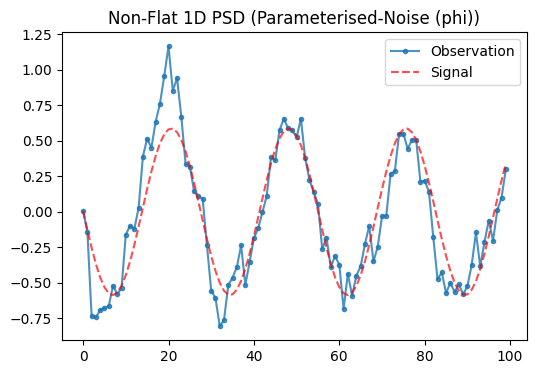

PSNR (clean/noisy):  14.635991875068655
L1 (clean/noisy):  0.14122601


In [58]:
# observation, signal, noise = create_1d_data_colored(n_samples=n_samples, n_depth=n_depth, phi=-1.0, decay=1.0, sigma=0.2)
observation, signal, noise = create_1d_data_colored_multi(n_samples=n_samples, n_depth=n_depth, phi=-1.0, decay=1.0, sigma=0.2)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Non-Flat 1D PSD (Parameterised-Noise (phi))')
plt.legend()
plt.show()


print('PSNR (clean/noisy): ', psnr_1d(signal[rn].reshape(1, 1, -1), observation[rn].reshape(1, 1, -1)))
print('L1 (clean/noisy): ', l1_loss_1d(signal[rn].reshape(1, 1, -1), observation[rn].reshape(1, 1, -1)))

In [59]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x000001867BA22510> <torch.utils.data.dataloader.DataLoader object at 0x000001866F51FCB0>


1D Non-Flat PSD - Colored Noise - Sine Signal

In [60]:
from modules.comp import unet
from modules.comp import diffusion_1d
from modules.comp import diff_trainer
import modules.utils.noise_create
import modules.utils.hmc

importlib.reload(modules.comp.unet)
importlib.reload(modules.comp.diffusion_1d)
importlib.reload(modules.comp.diff_trainer)
importlib.reload(modules.utils.noise_create)
importlib.reload(modules.utils.hmc)

from modules.comp import unet
from modules.comp import diffusion_1d
from modules.comp import diff_trainer
from modules.utils.noise_create import create_1d_data, create_1d_data_colored
import modules.utils.hmc

In [61]:
gmodel = unet.Unet1DGDiff(
    dim = 16, ## ? Something is wrong here?
    channels=1, 
)

## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (2, )
x_shape = (2, 1, 100)

print(x_shape, t_shape)

print('- UNET-summary -')
gmodel.summary(x_shape=x_shape, t_shape=t_shape)

### Just the diffusion framework
gdiffusion = diffusion_1d.GibbsDiff1D(
    gmodel,
    seq_length = 100,
    num_timesteps = 1000,
)

Dimension-Cluster:  16 32 64 128 256
(2, 1, 100) (2,)
- UNET-summary -
Careful, no alpha was given, set to 0
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (2, 1, 100)              0              
input_2 (InputLayer)                    (2,)                     0              
init_conv.proj (Conv1d)                 (2, 16, 100)             64             
init_conv.norm (LayerNorm)              (2, 100, 16)             32             
init_conv.act (SiLU)                    (2, 16, 100)             0              
down_blocks.0.block1.proj (Conv1d)      (2, 32, 100)             1568           
down_blocks.0.block1.norm (LayerNorm)   (2, 100, 32)             64             
down_blocks.0.block1.act (SiLU)         (2, 32, 100)             0              
down_blocks.0.block1 (BlockGDiff)       (2, 32,

In [62]:
print(signal_train.shape, signal_val[:50].shape)

torch.Size([8000, 100]) torch.Size([50, 100])


In [63]:
train_num_steps = 10000

In [ ]:
gtrainer = diff_trainer.Trainer1DGDiff(
    gdiffusion,
    signal_train,
    signal_val[:50],
    train_batch_size = 8,
    train_lr = 1e-5,
    train_num_steps = train_num_steps, # total training steps
    gradient_accumulate_every = 2,     # gradient accumulation steps
    ema_decay = 0.995,                 # exponential moving average decay
)

train_loss_curve, val_loss_curve = gtrainer.train()

Optimization Steps:  44%|████▍     | 4381/10000 [41:31<40:08,  2.33it/s]   

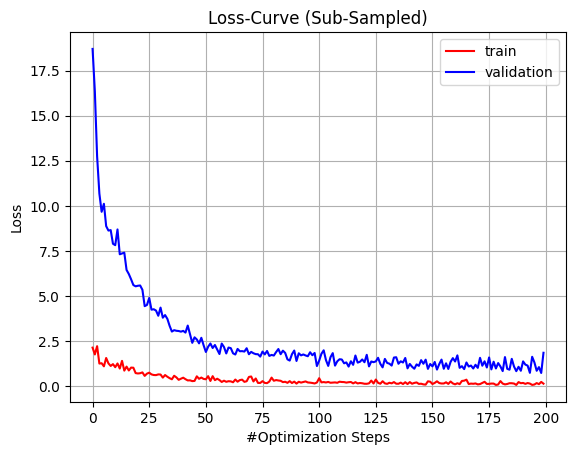

In [ ]:
fig = plt.Figure(figsize=(7, 7))

rate = 100
plt.plot(np.arange(train_num_steps // rate), train_loss_curve[::rate], color = 'red', label = 'train')
plt.plot(np.arange(train_num_steps // rate), val_loss_curve[::rate], color = 'blue', label = 'validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps')
plt.title('Loss-Curve (Sub-Sampled)')

plt.grid()
plt.legend()
plt.show()

Non-Blind denoising

In [34]:
yt, x0 = observation_val[0].view(1, 1, -1), signal_val[0].view(1, 1, -1)
print(x0.shape, yt.shape)

torch.Size([1, 1, 100]) torch.Size([1, 1, 100])


In [35]:
phi = -1.0
sigma = 0.2

In [47]:
sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

sigma_timestep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0])
print(sigma_timestep)

x_denoised = gdiffusion.denoise_samples_batch_time(yt, sigma_timestep, phi_ps=phi).cpu().numpy()
print(x_denoised.shape)

closest_discrete_timestep:  57
tensor([57])
(1, 1, 100)


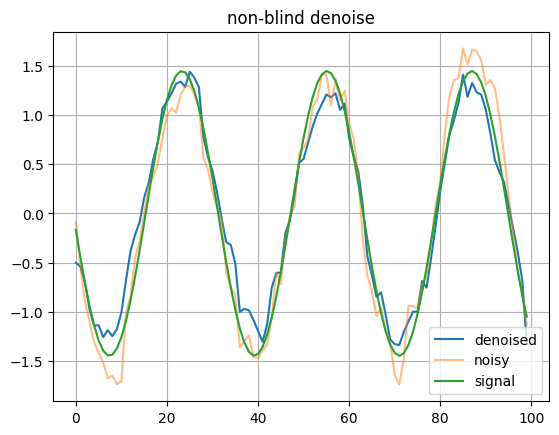

PSNR (clean/denoised):  14.089812673393364
L1 (clean/denoised):  0.16229196

PSNR (clean/noisy):  14.119913166216627
L1 (clean/noisy):  0.1578634


In [52]:
plt.plot(x_denoised[0][0], label = 'denoised')
plt.plot(yt[0][0], label = 'noisy', alpha = 0.5)
plt.plot(x0[0][0], label = 'signal')

plt.title('non-blind denoise')

plt.grid()
plt.legend()
plt.show()

print('PSNR (clean/denoised): ', psnr_1d(x0.cpu().numpy(), x_denoised))
print('L1 (clean/denoised): ', l1_loss_1d(x0.cpu().numpy(), x_denoised))

print()

print('PSNR (clean/noisy): ', psnr_1d(x0.cpu().numpy(), yt.cpu().numpy()))
print('L1 (clean/noisy): ', l1_loss_1d(x0.cpu().numpy(), yt.cpu().numpy()))

Noising -> Denosing (non-blind) (the multi-batching not working for either of denoising)

In [53]:
sigmas = [0.2] ## noise-amplitude
phis = [-1, 0, 1]

sigmas = [gdiffusion.get_closest_timestep(torch.tensor([s]).to(device), ret_sigma=True)[1].item() for s in sigmas]

torch.Size([1, 1, 100])
Sigma:  0.1986703872680664
Phi:  -1
torch.Size([1, 1, 100])


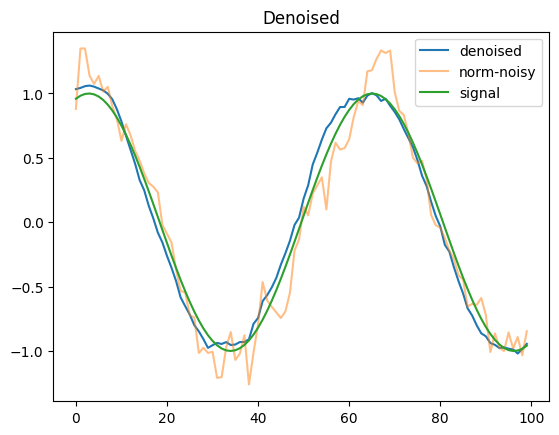

Sigma:  0.1986703872680664
Phi:  0
torch.Size([1, 1, 100])


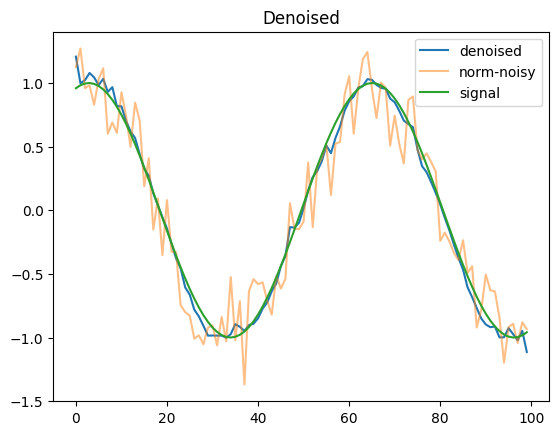

Sigma:  0.1986703872680664
Phi:  1
torch.Size([1, 1, 100])


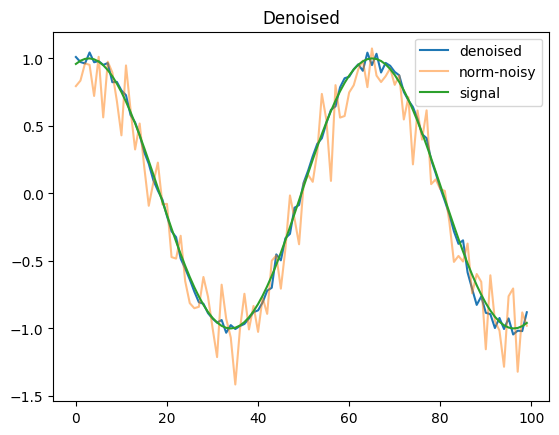

In [ ]:
x = signal_val[0].view(1, 1, -1)
print(x.shape)

for sigma_idx, sigma in enumerate(sigmas):
    for phi_idx, phi in enumerate(phis):
        
        print('Sigma: ', sigma)
        print('Phi: ', phi)

        # Make test data and auxilary variables
        sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
        alpha_bar_t = gdiffusion.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1).to(device)
        eps, psd =  get_colored_noise_1d(x.shape, phi=phi)
        eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t) * eps.to(device)
        y = x + eps # Noisy image
        psd = (torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t))**2 * psd.to(device) * x.shape[-1] * x.shape[-2]
        yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

        ## x_0_hat
        x_denoised = gdiffusion.denoise_samples_batch_time(yt, torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]), phi_ps=phi)
        print(x_denoised.shape)

        fig = plt.Figure(figsize=(6, 6))

        plt.plot(np.squeeze(x_denoised.detach().cpu().numpy()), label = 'denoised')
        plt.plot(np.squeeze(yt.detach().cpu().numpy()), label = 'norm-noisy', alpha = 0.5)
        plt.plot(np.squeeze(x), label = 'signal')

        plt.grid()
        plt.legend()
        plt.title('Denoised')
        plt.show()

        print('PSNR (clean/noisy): ', psnr_1d(x, x_denoised).item())
        print('L1 (clean/noisy): ', l1_loss_1d(x, x_denoised).item())

        ## E[x|y]
        # repeat = 20
        # yt_rep = yt.repeat(repeat, 1, 1)
        # t_rep = torch.tensor(sigma_timestep).unsqueeze(0).repeat(yt.shape[0]*repeat)
        # print(yt_rep.shape, t_rep.shape)
        
        # x_denoised_mean = gdiffusion.denoise_samples_batch_time(yt_rep, t_rep, phi_ps=phi)
        # x_denoised_mean = x_denoised_mean.reshape(repeat, yt.shape[0], 1, yt.shape[2], yt.shape[3]).mean(dim=0)
        # print(x_denoised_mean.shape)

Blind-Denoising (only inferencing SO need improvisation) (VERY IMPORTANT)

It needs y and yt(normalized based on alpha_bar_t) both for blind-denosing | So I'll need to have <code>sigma</code> all the time?

In [73]:
sigma = 0.2

In [74]:
y, x0 = observation_val[0].view(1, 1, -1), signal_val[0].view(1, 1, -1)
print(x0.shape, y.shape)

sigma_timestep = gdiffusion.get_closest_timestep(torch.tensor([sigma]).to(device)).item()
print('closest_discrete_timestep: ', sigma_timestep)

alpha_bar_t = gdiffusion.alpha_bar_t[sigma_timestep].reshape(-1, 1, 1).to(device)
yt = torch.sqrt(alpha_bar_t) * y 

print(y.shape, yt.shape)

torch.Size([1, 1, 100]) torch.Size([1, 1, 100])
closest_discrete_timestep:  57
torch.Size([1, 1, 100]) torch.Size([1, 1, 100])


In [75]:
print('x_0_hat:')

## x_0_hat, phi_hat -- point estimate - single chain run
phi_sampled, x_denoised = gdiffusion.run_gibbs_sampler(y, yt, num_chains_per_sample=1, n_it_gibbs=100, n_it_burnin=20)
print(phi_sampled.shape, x_denoised.shape)

x_0_hat:
torch.Size([1, 2]) torch.Size([1, 1, 100])


In [76]:
print(phi_sampled)

tensor([[0.3507, 0.3800]])


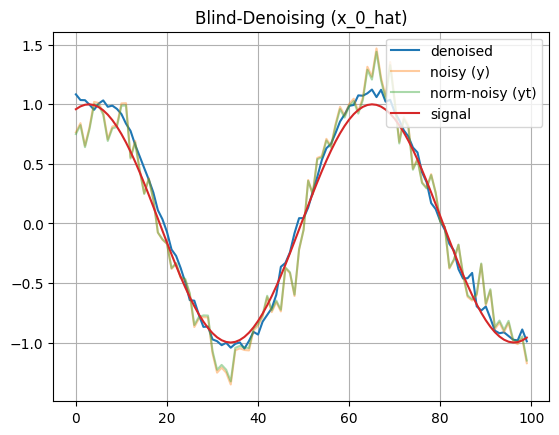

In [ ]:
# x_denoised = x_denoised.numpy()

plt.plot(x_denoised[0][0], label = 'denoised')
plt.plot(y[0][0], label = 'noisy (y)', alpha = 0.4)
plt.plot(yt[0][0], label = 'norm-noisy (yt)', alpha = 0.4)
plt.plot(x0[0][0], label = 'signal')

plt.legend()
plt.grid()
plt.title('Blind-Denoising (x_0_hat)')
plt.show()

print('PSNR (clean/noisy): ', psnr_1d(x0, x_denoised).item())
print('L1 (clean/noisy): ', l1_loss_1d(x0, x_denoised).item())

LATER (expectation over posterior joint distribution )

In [ ]:
print('E[X|Y]:')
## E[x|y] - expectation over posterior joint distribution 
phi_sampled_mean, x_denoised_mean = gdiffusion.blind_posterior_mean(y, yt) 
print(phi_sampled_mean.shape, x_denoised_mean.shape)

#### Questions -
1. we need to index the t to noisy image for normalizing it - how is that denoising blind then (we need y and yt (for posterior sampling))
2. Do we need to replicate the entire pipeline (architechture and data-training) (OR a subset would suffice)

### 2D Image Data (ImageNet)

Need to train on ~ 1.2M image samples (the Kaggle Imagenet subset)

In [ ]:
## ImageNet subset ~1k
import cv2 as cv
import torchvision
import torchvision.datasets

import os 
import zipfile

ModuleNotFoundError: No module named 'cv2'

In [ ]:
zip_path = "../data/archive.zip"
extract_dir = '../data/tiny-imagenet/'  # Use '.' to extract to current directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
train_data_path = '..'
train_imagenet_path = os.path.join(extract_dir, train_data_path)

img = cv.imread(train_imagenet_path)
print(img.shape)

fig = plt.figure(figsize = (7, 7))

plt.imshow(img)
plt.show()